In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
from scipy.stats import truncnorm
import matplotlib.pylab as pylab
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from scipy.stats import zscore
import xgboost as xgb
import lightgbm as lgb
import joblib

## Phân Tích

In [2]:
#tạo DataFrame với các cột đã được số hóa
df_raw = pd.read_csv('C:/CODE/SIC_BigData_Real-Estate-Price-Prediction/data/batdongsan/numerized/NhaO_numerized-dataset.csv',index_col=False)

In [3]:
rows  = df_raw[df_raw['MucGia'] < 200000000]
df_raw = df_raw.drop(index = rows.index)
rows  = df_raw[df_raw['MucGia'] > 200000000000]
df_raw = df_raw.drop(index = rows.index)

df_raw = df_raw.dropna(subset=['City', 'District', 'Ward','MucGia','SoTang','SoPhongNgu','SoToilet'])

df_raw = df_raw.drop(columns=['HuongBanCong','Unnamed: 0'])


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24205 entries, 5 to 45922
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DienTich    24205 non-null  float64
 1   DiaChi      24205 non-null  object 
 2   City        24205 non-null  float64
 3   District    24205 non-null  float64
 4   MucGia      24205 non-null  float64
 5   Lat         23869 non-null  float64
 6   Long        23869 non-null  float64
 7   MatTien     17245 non-null  float64
 8   PhapLy      22027 non-null  float64
 9   DuongVao    15305 non-null  float64
 10  HuongNha    7950 non-null   float64
 11  SoTang      24205 non-null  float64
 12  SoPhongNgu  24205 non-null  float64
 13  SoToilet    24205 non-null  float64
 14  NoiThat     17227 non-null  float64
 15  Ward        24205 non-null  float64
dtypes: float64(15), object(1)
memory usage: 3.1+ MB


In [5]:
df_raw = df_raw.drop(columns=['Lat','Long'])

In [6]:
# Hàm để sinh giá trị ngẫu nhiên có giới hạn trong khoảng cố định
def truncated_normal(mean, std, lower, upper, size):
    return truncnorm(
        (lower - mean) / std, (upper - mean) / std, loc=mean, scale=std).rvs(size)

# Hàm để điền các giá trị bị thiếu trong một cột số
def fill_missing_with_random(column):
    if column.dtype.kind in 'biufc':  # Kiểm tra nếu cột là số
        # Tính trung bình và độ lệch chuẩn của cột (bỏ qua giá trị bị thiếu)
        mean = np.mean(column.dropna())
        std = np.std(column.dropna())
        
        # Xác định vị trí các giá trị bị thiếu
        missing_indices = np.where(column.isnull())[0]
        
        # Sinh giá trị ngẫu nhiên nếu cột đó có các giá trị là giá trị phân loại (như số cho 8 hướng)
        if column.name == 'HuongNha':
            random_data = truncated_normal(mean, std, 1, 8, len(missing_indices))
        elif column.name == 'NoiThat':
            random_data = truncated_normal(mean, std, 0, 3, len(missing_indices))
        else:
            # Sinh giá trị ngẫu nhiên từ phân phối chuẩn
            random_data = np.random.normal(loc=mean, scale=std, size=len(missing_indices))
            # Đảm bảo không có giá trị âm
            random_data = np.abs(random_data)
        
        # Điền giá trị bị thiếu bằng các giá trị ngẫu nhiên đã sinh ra
        column.iloc[missing_indices] = random_data
        
    return column

def zero_round(value):
    if value < 0.5:
        return 0
    elif value < 1:
        return 1
    else:
        return np.floor(value)

df_raw['HuongNha'] = fill_missing_with_random(df_raw['HuongNha'])
df_raw['NoiThat'] = fill_missing_with_random(df_raw['NoiThat'])
df_raw['PhapLy'] = fill_missing_with_random(df_raw['PhapLy'])

# Làm tròn giá trị cho cột NoiThat, PhapLy, HuongNha
df_raw['NoiThat'] = df_raw['NoiThat'].apply(zero_round)
df_raw['PhapLy'] = df_raw['PhapLy'].apply(zero_round)
df_raw['HuongNha'] = np.floor(df_raw['HuongNha'])



C:\Users\quanp\AppData\Local\Temp\ipykernel_18788\2366744942.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column.iloc[missing_indices] = random_data
C:\Users\quanp\AppData\Local\Temp\ipykernel_18788\2366744942.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column.iloc[missing_indices] = random_data
C:\Users\quanp\AppData\Local\Temp\ipykernel_18788\2366744942.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column.iloc

In [7]:
df_raw.describe()

,DienTich,City,District,MucGia,MatTien,PhapLy,DuongVao,HuongNha,SoTang,SoPhongNgu,SoToilet,NoiThat,Ward
count,24205.000000,24205.000000,24205.000000,2.420500e+04,17245.000000,24205.000000,15305.000000,24205.000000,24205.000000,24205.000000,24205.000000,24205.000000,24205.000000
mean,107.193584,42.764264,433.928445,1.665236e+10,6.506114,1.089734,11.098968,4.520388,3.897583,5.297335,5.254617,1.873745,15532.489899
std,172.320227,36.598464,344.943141,2.170678e+10,5.251218,0.534046,13.343213,1.859500,1.752670,5.997421,6.296579,0.735971,12223.951486
min,0.280000,1.000000,1.000000,3.000000e+08,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,50.000000,1.000000,8.000000,5.500000e+09,4.000000,1.000000,5.000000,3.000000,3.000000,3.000000,3.000000,2.000000,328.000000
50%,73.500000,54.000000,555.000000,9.500000e+09,5.000000,1.000000,8.000000,5.000000,4.000000,4.000000,4.000000,2.000000,22045.000000
75%,110.000000,79.000000,766.000000,1.800000e+10,7.000000,1.000000,13.500000,6.000000,5.000000,5.000000,5.000000,2.000000,26968.000000
max,12468.000000,96.000000,964.000000,2.000000e+11,265.000000,4.000000,800.000000,8.000000,24.000000,188.000000,188.000000,3.000000,31999.000000


In [8]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24205 entries, 5 to 45922
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DienTich    24205 non-null  float64
 1   DiaChi      24205 non-null  object 
 2   City        24205 non-null  float64
 3   District    24205 non-null  float64
 4   MucGia      24205 non-null  float64
 5   MatTien     17245 non-null  float64
 6   PhapLy      24205 non-null  float64
 7   DuongVao    15305 non-null  float64
 8   HuongNha    24205 non-null  float64
 9   SoTang      24205 non-null  float64
 10  SoPhongNgu  24205 non-null  float64
 11  SoToilet    24205 non-null  float64
 12  NoiThat     24205 non-null  float64
 13  Ward        24205 non-null  float64
dtypes: float64(13), object(1)
memory usage: 2.8+ MB


In [9]:
#thêm một cột LogPrice để so sánh với các cột khác. Giúp giá trị nhỏ lại để dễ trực quan
df_raw['LogPrice'] = np.log(df_raw['MucGia'])

#thêm cột USD để về sau xây dựng mô hình với giá USD hạn chế được sai số do VND quá lớn (tỉ giá đổi 25k / 1$)
df_raw['USD']=df_raw['MucGia'].astype(float)/25000

In [10]:
# Thiết kế biểu đồ
rcParams = {'xtick.labelsize':'14','ytick.labelsize':'14','axes.labelsize':'16'}

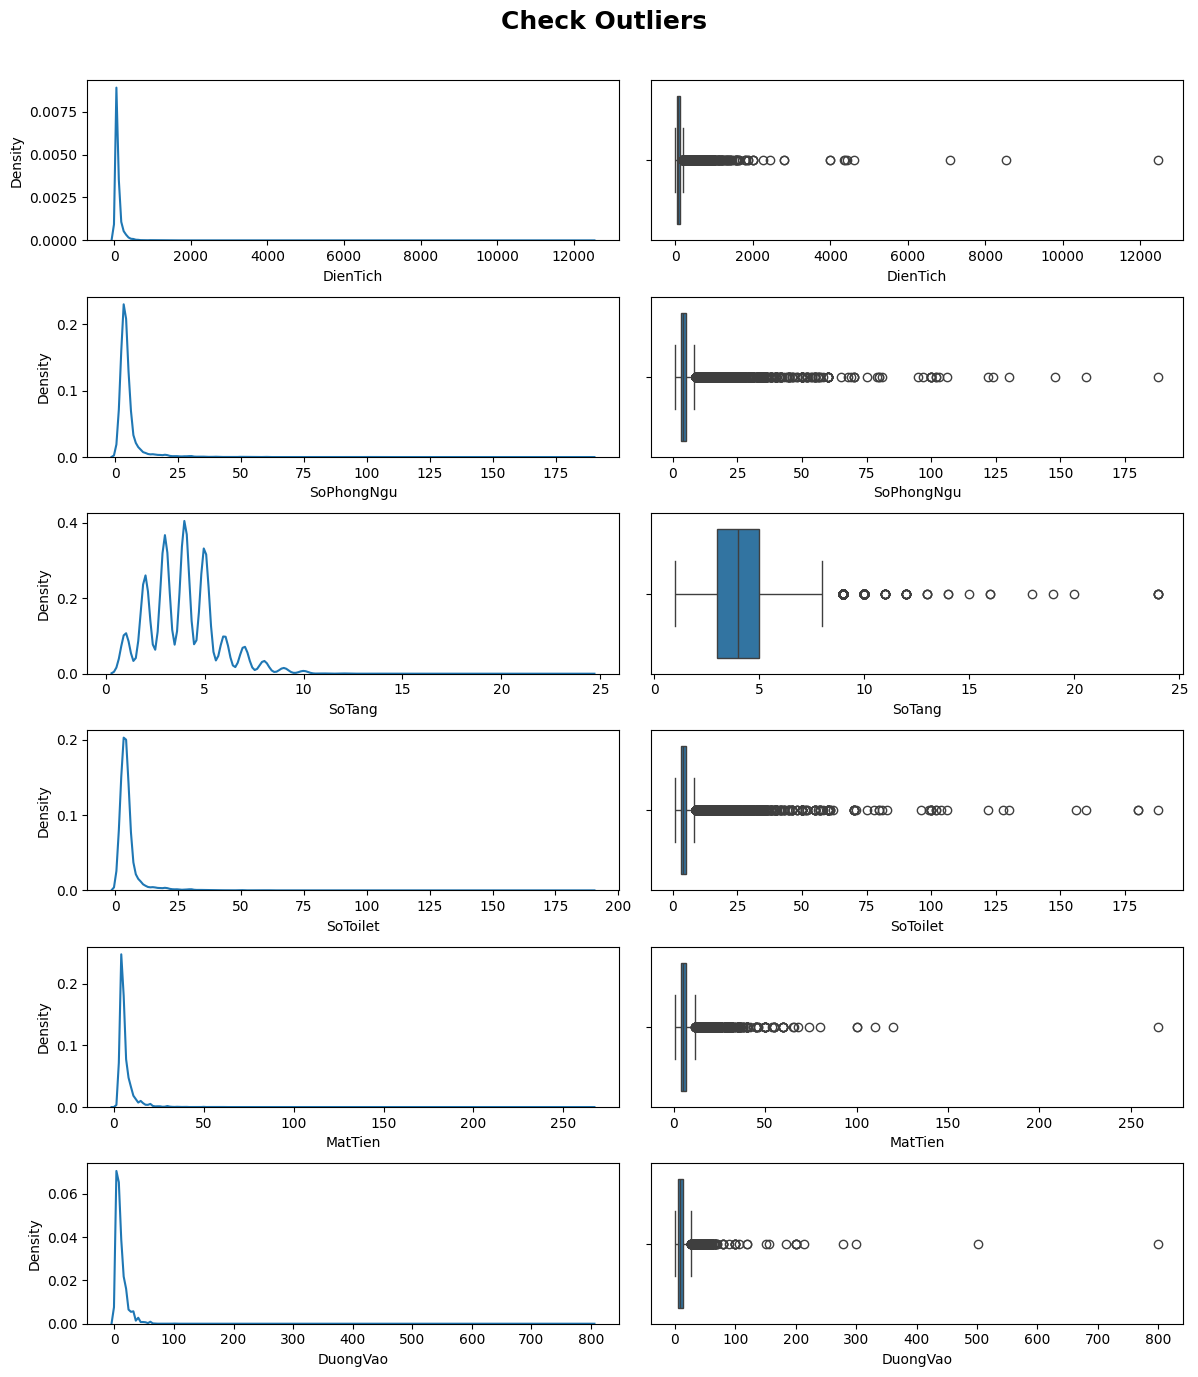

In [11]:
fig, ax = plt.subplots(6,2, figsize = (12,14))

fig.suptitle('Check Outliers', size = 18, fontweight="bold")
sns.kdeplot(ax= ax[0,0], data = df_raw, x = 'DienTich')
sns.boxplot(ax= ax[0,1], data = df_raw, x = 'DienTich')
sns.kdeplot(ax= ax[1,0], data = df_raw, x = 'SoPhongNgu')
sns.boxplot(ax= ax[1,1], data = df_raw, x = 'SoPhongNgu')
sns.kdeplot(ax= ax[2,0], data = df_raw, x = 'SoTang')
sns.boxplot(ax= ax[2,1], data = df_raw, x = 'SoTang')
sns.kdeplot(ax= ax[3,0], data = df_raw, x = 'SoToilet')
sns.boxplot(ax= ax[3,1], data = df_raw, x = 'SoToilet')
sns.kdeplot(ax= ax[4,0], data = df_raw, x = 'MatTien')
sns.boxplot(ax= ax[4,1], data = df_raw, x = 'MatTien')
sns.kdeplot(ax= ax[5,0], data = df_raw, x = 'DuongVao')
sns.boxplot(ax= ax[5,1], data = df_raw, x = 'DuongVao')


pylab.rcParams.update(rcParams)
fig.tight_layout()
fig.subplots_adjust(top=0.93)
plt.show()

Diện Tích: tập trung nhiều trong khoảng dưới 1000 m2  
Số Phòng Ngủ: khoảng dưới 13 phòng  
Số Tầng: dưới 8 tầng  
Số Toilet: dưới 13 phòng  
Mặt Tiền: dưới 20 m  
Đường Vào: dưới 40 m  
Diện Tích, Số Phòng Ngủ, Số Toilet, Mặt Tiền, Đường Vào có nhiều giá trị lớn vượt giá trị tập trung min-max (outlier)

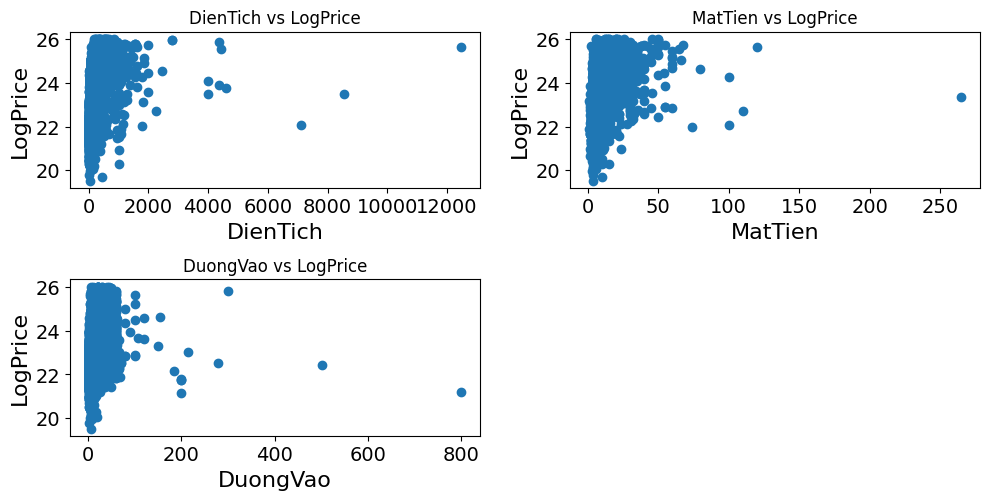

In [12]:
def scatter(x,fig):
    plt.subplot(5,2,fig)
    plt.scatter(df_raw[x],df_raw['LogPrice'])
    plt.title(x+' vs LogPrice')
    plt.ylabel('LogPrice')
    plt.xlabel(x)


plt.figure(figsize=(10,12))


scatter('DienTich', 1)
scatter('MatTien', 2)
scatter('DuongVao', 3)
plt.tight_layout()

Diện tích, mặt tiền, đường vào có ảnh hưởng đến mức giá. vẫn có 1 vài điểm giá trị ngoại lệ có thể là giá trị rác, hoặc do ảnh hưởng bởi các nhãn khác

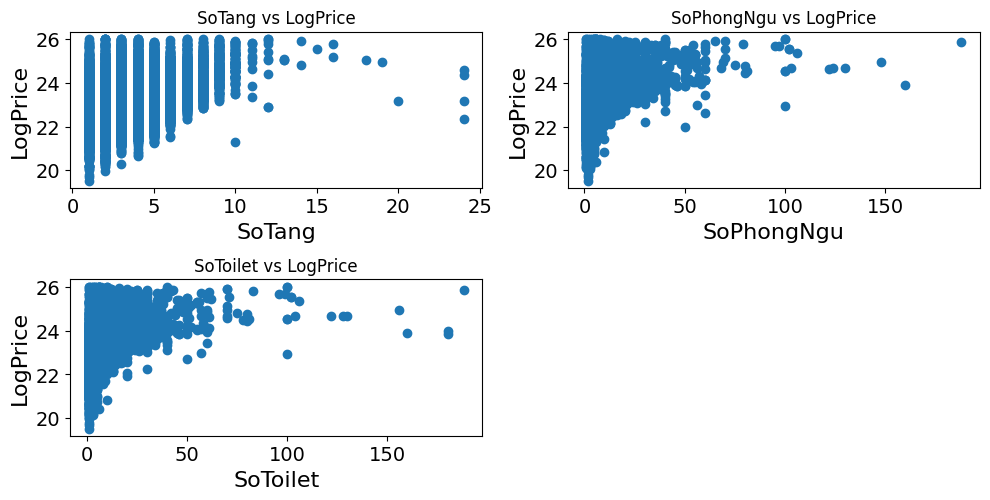

In [13]:
plt.figure(figsize=(10,12))

scatter('SoTang', 1)
scatter('SoPhongNgu', 2)
scatter('SoToilet', 3)

plt.tight_layout()

số phòng ngủ và số Toilet có ảnh hưởng đến mức giá  
số tầng không ảnh hưởng nhiều đến mức giá

C:\Users\quanp\AppData\Local\Temp\ipykernel_18788\35129562.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_raw['HuongNha'], y=df_raw['USD'], palette="plasma")


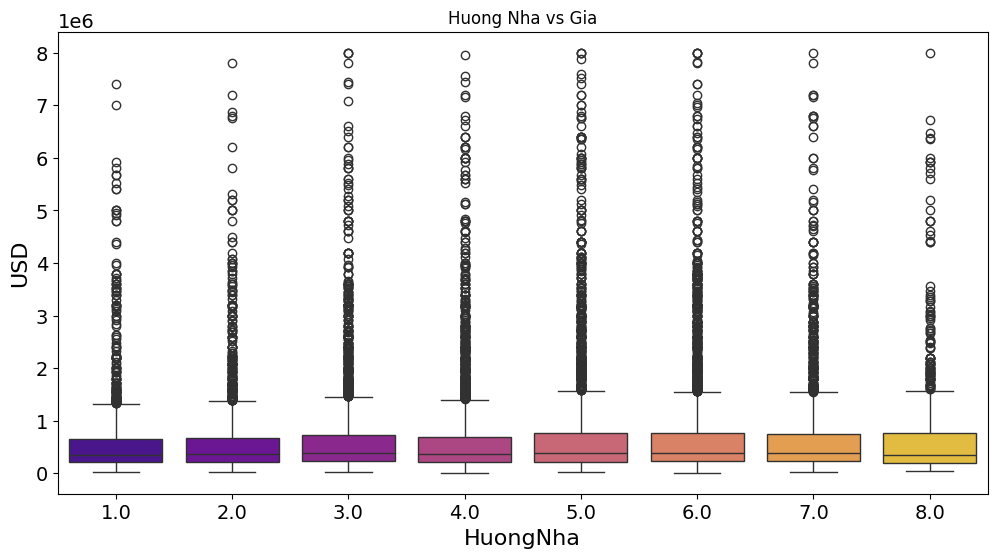

C:\Users\quanp\AppData\Local\Temp\ipykernel_18788\35129562.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_raw['NoiThat'], y=df_raw['USD'], palette="plasma")


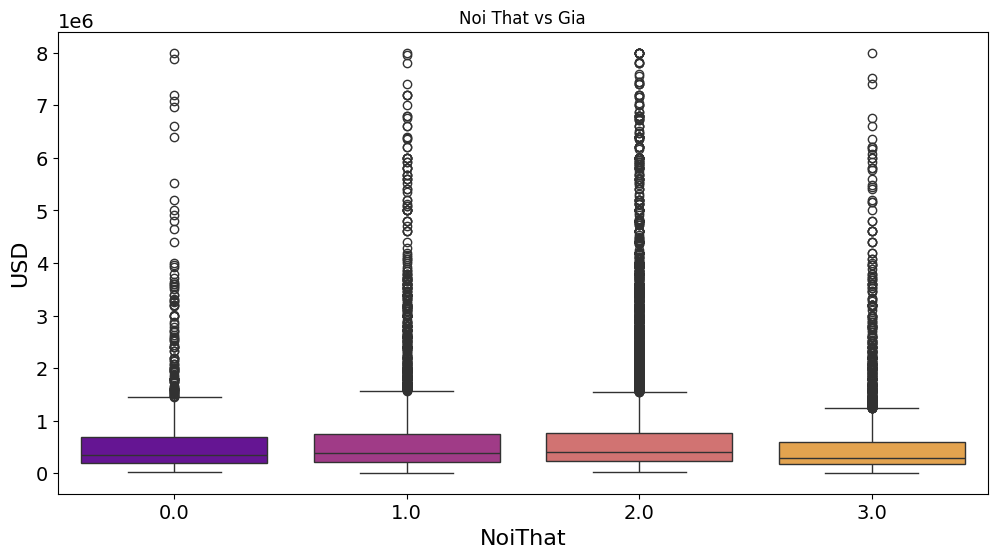

C:\Users\quanp\AppData\Local\Temp\ipykernel_18788\35129562.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_raw['PhapLy'], y=df_raw['USD'], palette="plasma")


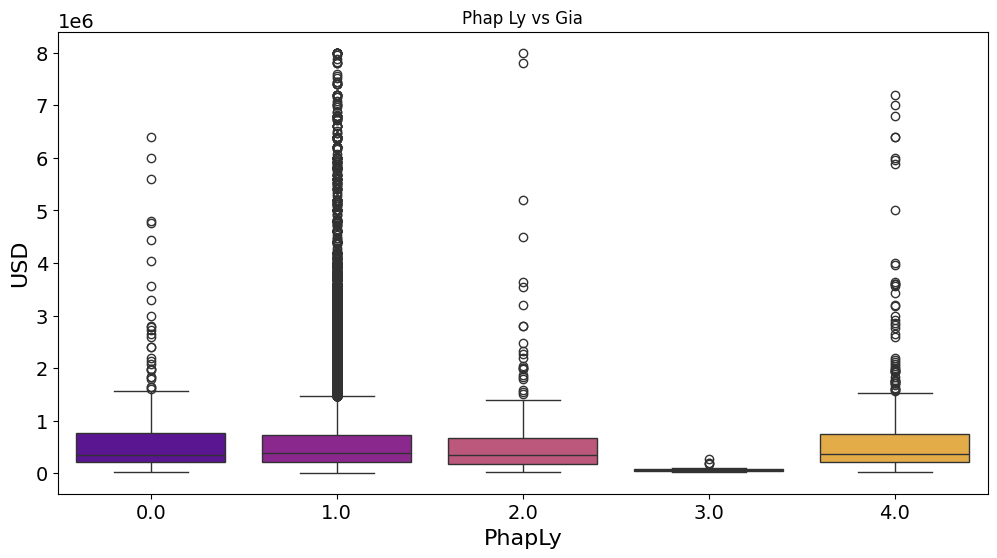

In [14]:
# Setting the figure size for the plots
plt.rcParams['figure.figsize'] = (12, 6)

# Creating the box plots

# sns.boxplot(x=df_raw['HuongBanCong'], y=df_raw['USD'], palette="plasma")
# plt.title('Huong Ban Cong vs Gia')
# plt.show()

sns.boxplot(x=df_raw['HuongNha'], y=df_raw['USD'], palette="plasma")
plt.title('Huong Nha vs Gia')
plt.show()

sns.boxplot(x=df_raw['NoiThat'], y=df_raw['USD'], palette="plasma")
plt.title('Noi That vs Gia')
plt.show()

sns.boxplot(x=df_raw['PhapLy'], y=df_raw['USD'], palette="plasma")
plt.title('Phap Ly vs Gia')
plt.show()

Nội thất, pháp lý ảnh hưởng giá  
Hướng nhà không ảnh hưởng nhiều đến giá

In [9]:
# Hàm để tải dữ liệu JSON vào một từ điển
def load_dvhc_dict(file_name):
    with open(file_name, "r", encoding="utf8") as dvhc_file:
        dvhc_json = json.load(dvhc_file)
        dvhc_dict = {}

        for level_1_key, level_1 in dvhc_json.items():
            dvhc_dict[level_1_key] = level_1["name"]
            for level_2_key, level_2 in level_1["level2s"].items():
                dvhc_dict[level_2_key] = level_2["name"]
                for level_3_key, level_3 in level_2["level3s"].items():
                    dvhc_dict[level_3_key] = level_3["name"]

    return dvhc_dict

# Đường dẫn tới dữ liệu JSON
json_path = "C:/CODE/SIC_BigData_Real-Estate-Price-Prediction/data/donvihanhchinhvn/dvhcvn_2024.json"
json_path_1 = "C:/CODE/SIC_BigData_Real-Estate-Price-Prediction/data/donvihanhchinhvn/dvhcvn_2020.json"

# Tải từ điển
try:
    dvhc_dict = load_dvhc_dict(json_path)
    dvhc_dict_1 = load_dvhc_dict(json_path_1)
except KeyError as e:
    print(f"Lỗi: {e}")
    dvhc_dict = {}
    dvhc_dict_1 = {}

# Hàm để lấy tên từ ID với việc debug và chuyển đổi từ chuỗi
def get_name_from_id(id, dvhc_dict, dvhc_dict_1):
    if pd.isna(id):
        return "ID không tìm thấy"
    id_str = str(int(id)) if not isinstance(id, str) else id
    if id_str in dvhc_dict:
        return dvhc_dict[id_str]
    if id_str in dvhc_dict_1:
        return dvhc_dict_1[id_str]
    return "ID không tìm thấy"

# Hàm để định dạng ID với các số 0 đứng đầu
def format_id(id, length):
    try:
        return str(int(id)).zfill(length)  # Chuyển thành int trước khi zfill để xử lý số float
    except ValueError:
        return None  # Trong trường hợp ID không hợp lệ

# Hàm để chuyển đổi ID của thành phố, quận, và phường thành tên với định dạng và theo dõi lỗi
def convert_ids_to_names(df, dvhc_dict, dvhc_dict_1):
    # Chuyển đổi cho Thành phố
    df['City'] = df['City'].apply(lambda x: get_name_from_id(format_id(x, 2), dvhc_dict, dvhc_dict_1))
    # Chuyển đổi cho Quận
    df['District'] = df['District'].apply(lambda x: get_name_from_id(format_id(x, 3), dvhc_dict, dvhc_dict_1))
    # Chuyển đổi cho Phường
    df['Ward'] = df['Ward'].apply(lambda x: get_name_from_id(format_id(x, 5), dvhc_dict, dvhc_dict_1))
    return df

# Tạo một bản sao của df_raw
df_copy = df_raw.copy()

# Áp dụng hàm chuyển đổi vào bản sao của DataFrame
df_copy = convert_ids_to_names(df_copy, dvhc_dict, dvhc_dict_1)

In [11]:
frame1 = df_copy[["DiaChi",'City','District','Ward','NoiThat','HuongNha','PhapLy','MucGia','USD']]
bins = [40000,90000,250000,118366500]

In [12]:
def Analyst(col):
    temp = frame1.copy()
    table = temp.groupby([col])['USD'].mean()
    temp = temp.merge(table.reset_index(), how='left', on=col)
    cars_bin = ['Low', 'Medium', 'High']
    frame1['range'] = pd.cut(temp['USD_x'], bins, right=False, labels=cars_bin)
    plt.rcParams['figure.figsize'] = (18, 8)
    df = pd.DataFrame(frame1.groupby([col, 'range'])['USD'].mean().unstack(fill_value=0))
    df.plot.bar()
    plt.title('House Range vs Price')
    plt.show()

C:\Users\quanp\AppData\Local\Temp\ipykernel_18696\1922501046.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame1['range'] = pd.cut(temp['USD_x'], bins, right=False, labels=cars_bin)
C:\Users\quanp\AppData\Local\Temp\ipykernel_18696\1922501046.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = pd.DataFrame(frame1.groupby([col, 'range'])['USD'].mean().unstack(fill_value=0))


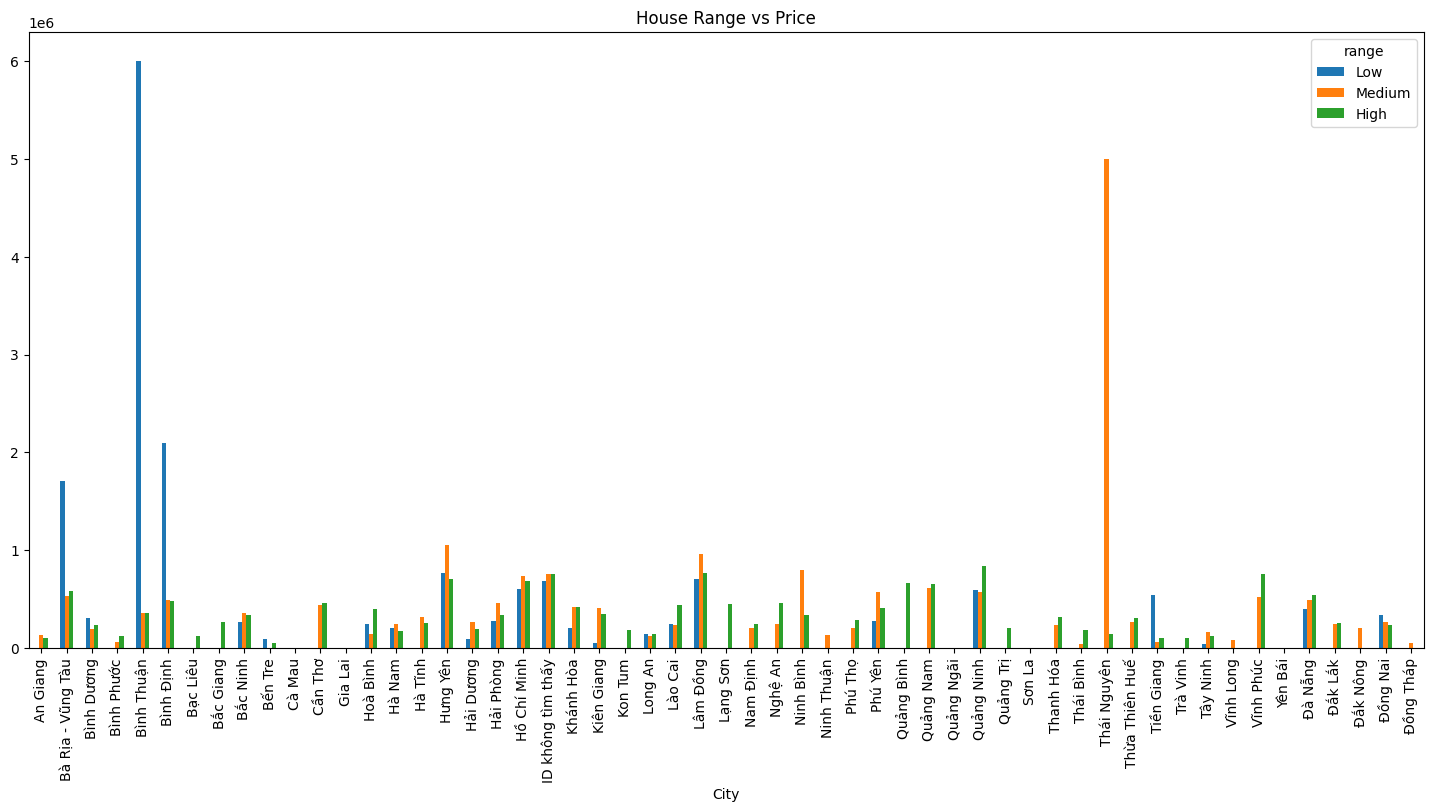

In [13]:
Analyst('City')

Các thành phố ở Việt Nam có ảnh hưởng lớn đến mức giá

In [15]:
# Lấy giá trị USD cao nhất
max_usd_row = df_raw.loc[df_raw['USD'].idxmax(), ['USD', 'City']]

# Lấy giá trị USD thấp nhất
min_usd_row = df_raw.loc[df_raw['USD'].idxmin(), ['USD', 'City']]

# In ra giá trị
print("Giá trị USD cao nhất:")
print(max_usd_row)

print("\nGiá trị USD thấp nhất:")
print(min_usd_row)

Giá trị USD cao nhất:
USD     8000000.0
City         79.0
Name: 2329, dtype: object

Giá trị USD thấp nhất:
USD     12000.0
City       80.0
Name: 7692, dtype: object


Bộ dữ thu được ta thấy  
thành Phố HCM có mức giá cao nhất: 8 000 000$ sấp xỉ 200 tỷ VND  
Tỉnh Long An có mức giá thấp nhất: 12 000$ sấp xỉ 300 triệu VND  
với 25 000 = 1$

In [16]:
df_raw = df_raw.drop(columns=['DiaChi'])

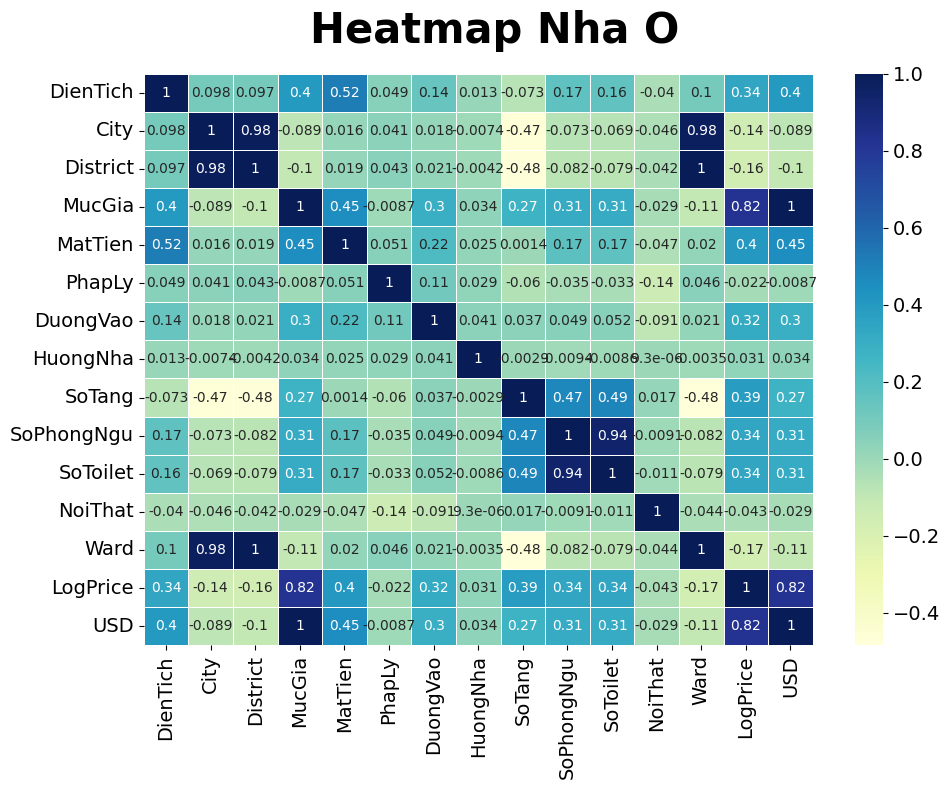

In [17]:
fig = plt.figure(figsize=(10,8))

sns.heatmap(df_raw.corr(), annot = True, cmap='YlGnBu', linewidth=.5)
fig.suptitle('Heatmap Nha O',fontsize=30, fontweight="bold")
pylab.rcParams.update(rcParams)
fig.tight_layout()
plt.show()

ta thấy Thành Phố, Huyện, Đường có mối liên kết mạnh với nhau  
Số Phòng Ngủ, Số Toilet có mối liên kết mạnh với nhau  
mấy thằng còn lại nó có mối liên kết yếu và độc lập với nhau

In [18]:
df_raw.isna().sum()

DienTich         0
City             0
District         0
MucGia           0
MatTien       6960
PhapLy           0
DuongVao      8900
HuongNha         0
SoTang           0
SoPhongNgu       0
SoToilet         0
NoiThat          0
Ward             0
LogPrice         0
USD              0
dtype: int64

In [19]:
#Lưu dữ liệu chuẩn hóa vào file csv
df_raw.to_csv('Standardize_House.csv')

## Xây Dựng Mô Hình

In [20]:
df_dropped_2 = pd.read_csv('C:/CODE/SIC_BigData_Real-Estate-Price-Prediction/notebooks/Standardize_House.csv',index_col=False)
df_dropped_2 = df_dropped_2.drop(columns=['Unnamed: 0'])

In [21]:
df_dropped_2.describe()

,DienTich,City,District,MucGia,MatTien,PhapLy,DuongVao,HuongNha,SoTang,SoPhongNgu,SoToilet,NoiThat,Ward,LogPrice,USD
count,24205.000000,24205.000000,24205.000000,2.420500e+04,17245.000000,24205.000000,15305.000000,24205.000000,24205.000000,24205.000000,24205.000000,24205.000000,24205.000000,24205.000000,2.420500e+04
mean,107.193584,42.764264,433.928445,1.665236e+10,6.506114,1.089734,11.098968,4.520388,3.897583,5.297335,5.254617,1.873745,15532.489899,23.062249,6.660946e+05
std,172.320227,36.598464,344.943141,2.170678e+10,5.251218,0.534046,13.343213,1.859500,1.752670,5.997421,6.296579,0.735971,12223.951486,0.921621,8.682711e+05
min,0.280000,1.000000,1.000000,3.000000e+08,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,19.519293,1.200000e+04
25%,50.000000,1.000000,8.000000,5.500000e+09,4.000000,1.000000,5.000000,3.000000,3.000000,3.000000,3.000000,2.000000,328.000000,22.428014,2.200000e+05
50%,73.500000,54.000000,555.000000,9.500000e+09,5.000000,1.000000,8.000000,5.000000,4.000000,4.000000,4.000000,2.000000,22045.000000,22.974558,3.800000e+05
75%,110.000000,79.000000,766.000000,1.800000e+10,7.000000,1.000000,13.500000,6.000000,5.000000,5.000000,5.000000,2.000000,26968.000000,23.613638,7.200000e+05
max,12468.000000,96.000000,964.000000,2.000000e+11,265.000000,4.000000,800.000000,8.000000,24.000000,188.000000,188.000000,3.000000,31999.000000,26.021583,8.000000e+06


In [22]:
df_dropped_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24205 entries, 0 to 24204
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DienTich    24205 non-null  float64
 1   City        24205 non-null  float64
 2   District    24205 non-null  float64
 3   MucGia      24205 non-null  float64
 4   MatTien     17245 non-null  float64
 5   PhapLy      24205 non-null  float64
 6   DuongVao    15305 non-null  float64
 7   HuongNha    24205 non-null  float64
 8   SoTang      24205 non-null  float64
 9   SoPhongNgu  24205 non-null  float64
 10  SoToilet    24205 non-null  float64
 11  NoiThat     24205 non-null  float64
 12  Ward        24205 non-null  float64
 13  LogPrice    24205 non-null  float64
 14  USD         24205 non-null  float64
dtypes: float64(15)
memory usage: 2.8 MB


In [23]:
X = df_dropped_2.drop(['MucGia','LogPrice','USD'], axis=1)
y = df_dropped_2['USD']

In [24]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
# Lưu scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

## Random Forest

In [27]:
# Khởi tạo và huấn luyện mô hình Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [28]:
# Dự đoán và đánh giá mô hình
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {rmse}')
print(f'R² Score: {r2}')

Root Mean Squared Error: 396609.6742177488
R² Score: 0.808140675040837


In [29]:
# Grid Search cho tối ưu hóa siêu tham số của RandomForest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Khởi tạo mô hình RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)

# Tìm kiếm siêu tham số tối ưu
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Huấn luyện GridSearch
grid_search.fit(X_train_scaled, y_train)

# Lấy mô hình tốt nhất
best_rf_model = grid_search.best_estimator_

# Dự đoán với mô hình tốt nhất
y_pred_rf = best_rf_model.predict(X_test_scaled)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f'RMSE cho mô hình RandomForest: {rmse_rf}')
print(f'R² score cho mô hình RandomForest: {r2_rf}')

Fitting 3 folds for each of 81 candidates, totalling 243 fits
RMSE cho mô hình RandomForest: 396244.7709141
R² score cho mô hình RandomForest: 0.808493555464278


## XGBoost

In [30]:
# Tạo và huấn luyện mô hình XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Dự đoán trên tập kiểm tra
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Tính toán các chỉ số đánh giá
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f'XGBoost - Root Mean Squared Error: {rmse_xgb}')
print(f'XGBoost - R² Score: {r2_xgb}')

XGBoost - Root Mean Squared Error: 389090.82836737524
XGBoost - R² Score: 0.8153461815908263


## LightGBM

In [31]:
# Tạo và huấn luyện mô hình LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
lgb_model.fit(X_train_scaled, y_train)

# Dự đoán trên tập kiểm tra
y_pred_lgb = lgb_model.predict(X_test_scaled)

# Tính toán các chỉ số đánh giá
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mse_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

print(f'LightGBM - Root Mean Squared Error: {rmse_lgb}')
print(f'LightGBM - R² Score: {r2_lgb}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1174
[LightGBM] [Info] Number of data points in the train set: 19364, number of used features: 12
[LightGBM] [Info] Start training from score 661115.079205
LightGBM - Root Mean Squared Error: 379928.359807311
LightGBM - R² Score: 0.823940391935216


## kết hợp 3 thuật toán RR, GBR, LightGBM

In [32]:
#kết hợp 3 thuật toán RandomForestRegressor,GradientBoostingRegressor,LGBMRegressor để dự đoán
estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xg', xgb.XGBRegressor(n_estimators=100, random_state=42)),
    ('lgb', lgb.LGBMRegressor(n_estimators=100, random_state=42))
]

# Tạo và huấn luyện mô hình Stacking Regressor
stacking_model = StackingRegressor(estimators=estimators, final_estimator=Ridge())
stacking_model.fit(X_train_scaled, y_train)

# Dự đoán trên tập kiểm tra
y_pred_stacking = stacking_model.predict(X_test_scaled)

# Tính toán các chỉ số đánh giá
mse_stacking = mean_squared_error(y_test, y_pred_stacking)
rmse_stacking = np.sqrt(mse_stacking)
r2_stacking = r2_score(y_test, y_pred_stacking)

print(f'Mean Squared Error: {mse_stacking}')
print(f'Stacking Regressor - Root Mean Squared Error: {rmse_stacking}')
print(f'Stacking Regressor - R² Score: {r2_stacking}')

# Lưu mô hình
joblib.dump(stacking_model, 'stacking_model.pkl')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1174
[LightGBM] [Info] Number of data points in the train set: 19364, number of used features: 12
[LightGBM] [Info] Start training from score 661115.079205
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1150
[LightGBM] [Info] Number of data points in the train set: 15491, number of used features: 12
[LightGBM] [Info] Start training from score 656945.424551
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

['stacking_model.pkl']

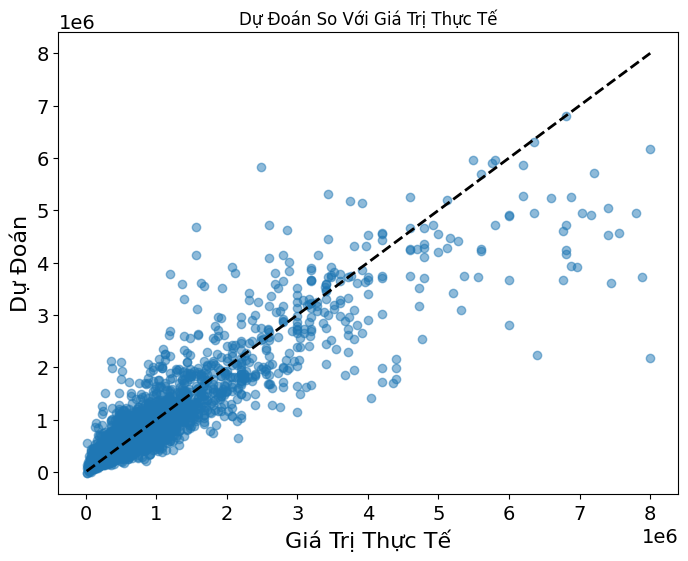

In [33]:
# Vẽ biểu đồ dự đoán so với giá trị thực tế
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_stacking, alpha=0.5)
plt.xlabel('Giá Trị Thực Tế')
plt.ylabel('Dự Đoán')
plt.title('Dự Đoán So Với Giá Trị Thực Tế')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

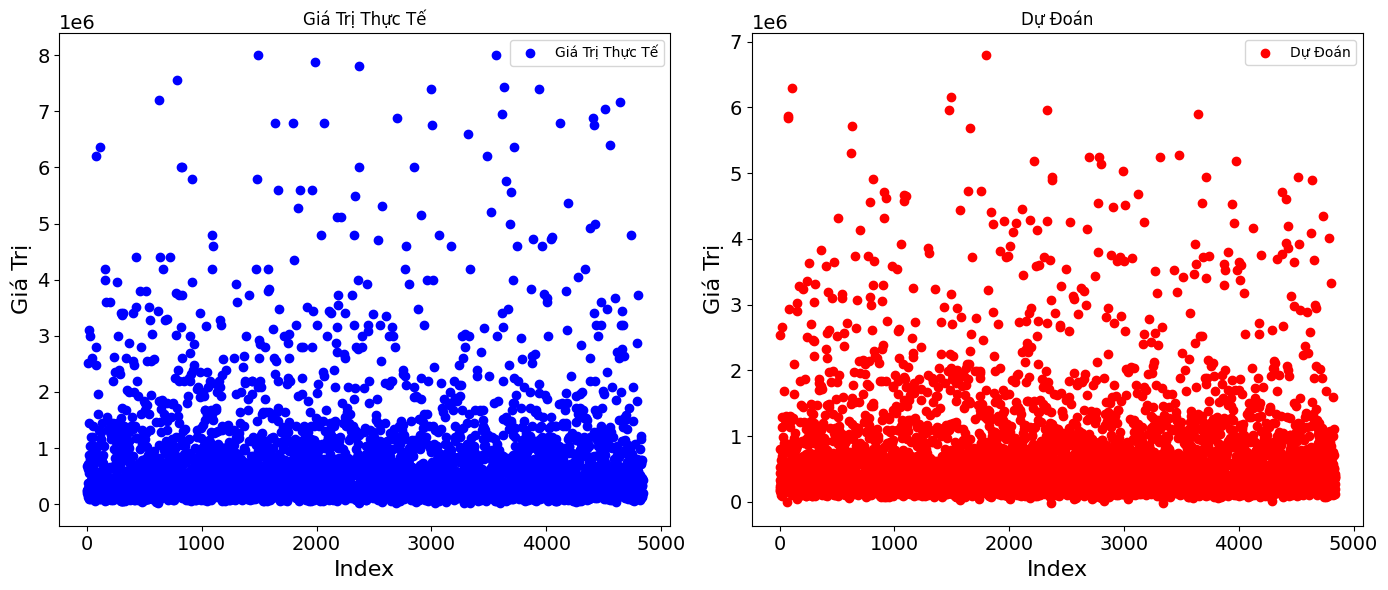

In [34]:
# Vẽ biểu đồ giá trị thực tế
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)  # 1 hàng, 2 cột, 1st subplot
plt.scatter(range(len(y_test)), y_test, color='blue', label='Giá Trị Thực Tế')
plt.xlabel('Index')
plt.ylabel('Giá Trị')
plt.title('Giá Trị Thực Tế')
plt.legend()

# Vẽ biểu đồ dự đoán
plt.subplot(1, 2, 2)  # 1 hàng, 2 cột, 2nd subplot
plt.scatter(range(len(y_pred_stacking)), y_pred_stacking, color='red', label='Dự Đoán')
plt.xlabel('Index')
plt.ylabel('Giá Trị')
plt.title('Dự Đoán')
plt.legend()

plt.tight_layout()
plt.show()